# Advanced Lane Lines Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Useful Definitions And Functions

In [35]:
OUTPUT_DIR = "./output_images/"

In [157]:
import numpy as np
import cv2
import glob
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Print iterations progress
def printProgressBar(iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█'):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix), end = '\r')
    # Print New Line on Complete
    if iteration == total: 
        print()
        
def percentage(percentage, value):
    """
    Returns the percentage of a given value.
    @params:
        percentage - Required  : The percentage of the value to calculate.
        value      - Required  : The value
    """
    return value * percentage / 100

def draw_line(img, line, color = [255, 0, 0], thickness = 10):
    """
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for x1,y1,x2,y2 in line:
        cv2.line(img, (x1, y1), (x2, y2), color, thickness)

## Camera Calibration

To implement the camera calibration, I used the methods explained on class. First, I took all the images from the chessboard, and using **cv2.findChessboardCorners** function, I get the corners from the chessboard images, that were saved in the img_points array to be used later with the **cv2.calibrateCamera** function. The code is provided next. There were some images my algorithm couldn't find corners at all, because the chessboard is not shown complete.

In [441]:
%matplotlib qt

VAR_TITLE  = "Processing images..."
VAR_SUFIX  = "Done."
ROWS       = 6
COLUMNS    = 9

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp       = np.zeros((ROWS * COLUMNS, 3), np.float32)
objp[:,:2] = np.mgrid[0:COLUMNS, 0:ROWS].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
obj_points = [] # 3d points in real world space
img_points = [] # 2d points in image plane.

# Make a list of calibration images
calibration_images = glob.glob('camera_cal/calibration*.jpg')
image_shape        = None
total_images       = len(calibration_images)
messages           = []
error_images       = []
result_images      = []

calibration_images.sort()

# Step through the list and search for chessboard corners
for idx, fname in enumerate(calibration_images):
    img  = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    if (image_shape == None):
        image_shape = gray.shape
        
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (COLUMNS, ROWS), None)

    # If found, add object points, image points
    if ret == True:
        obj_points.append(objp)
        img_points.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (COLUMNS, ROWS), corners, ret)
        
        #Save image
        write_name = OUTPUT_DIR + 'camera_calibration/corners_found_' + str(idx) + '.jpg'
        cv2.imwrite(write_name, img)
        result_images.append(img)
    else:
        # Warn if no corners found
        messages.append("No corners found on image '{}'".format(fname))
        error_images.append(img)
        
    printProgressBar(idx, total_images, prefix = VAR_TITLE, suffix = VAR_SUFIX, length = 20,)

printProgressBar(total_images, total_images, prefix = VAR_TITLE, suffix = VAR_SUFIX, length = 20)

print()
print("Processed {} ({}) image(s).".format(len(calibration_images), image_shape))
print()

if (len(messages) > 0):
    print("Warnings found:")

for i in range(len(messages)):
    print("● {}".format(messages[i]))

Processing images... |████████████████████| 100.0% Done.

Processed 20 ((720, 1280)) image(s).

Warnings found:
● No corners found on image 'camera_cal/calibration1.jpg'
● No corners found on image 'camera_cal/calibration4.jpg'
● No corners found on image 'camera_cal/calibration5.jpg'


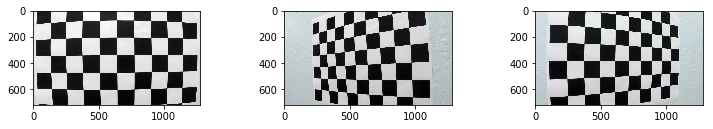

In [448]:
num_rows = 1
num_cols = 3

fig = plt.figure(figsize=(12, 12))
gs  = gridspec.GridSpec(num_rows, num_cols, wspace = 0.5, hspace = 0.5)
ax  = [plt.subplot(gs[i]) for i in range(num_rows * num_cols)]

for i in range(len(error_images)):
    ax[i].imshow(error_images[i])

This images cannot be processed by the find chessboard corners method, given that parts of the chessboard are obscured or not shown in the image.

### Output Images From Camera Calibration

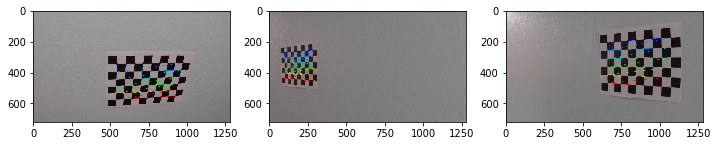

In [446]:
%matplotlib inline

num_rows = 1
num_cols = 3

fig = plt.figure(figsize=(12, 12))
gs  = gridspec.GridSpec(num_rows, num_cols)
ax  = [plt.subplot(gs[i]) for i in range(num_rows * num_cols)]

for i in range(3):
    ax[i].imshow(result_images[i])

## Image Processing Pipeline

### Image transformation functions

Here I implemented some useful functions that I needed for the rest of the project. 

In [306]:
# I only calculate this once.
# Camera calibration data
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, image_shape[::-1], None, None)

# Perspective transform
search_area_vertices  = np.float32([[570, 460], [180, 720], [1130, 720], [710, 460]])
warp_destination_area = np.float32([[320, 0], [320, 720], [960,720], [960, 0]])
p_mtx                 = cv2.getPerspectiveTransform(search_area_vertices, warp_destination_area)

def get_search_area_vertices():
    """
    Gets the vertices of the area where the lanes may be. 
    """  
    return np.float32([[575, 460], [188, 720], [1125, 720], [705, 460]])

def undistort(img):
    """
    Undistorts a given image.
    @params:
        img   - Required  : The image (byte array).
    """
    return cv2.undistort(img, mtx, dist)

def apply_sobel(img, orient = 'x', thresh_min = 20, thresh_max = 100, kernel_size = 3):
    """
    Applies a sobel filter to the given image.
    @params:
        img         - Required: The image (byte array).
        orient      - Optional: The orientation for the filter.
        thresh_min  - Optional: The lower limit for the thresholding.
        thresh_max  - Optional: The upper limit for the thresholding.
        kernel_size - Optional: The size of the kernel.
    """
    #Get the red channel
    working_image = img[:,:,0]
    sobel         = None
    
    # Sobel
    if (orient == 'x'):
        sobel = cv2.Sobel(working_image, cv2.CV_64F, 1, 0, kernel_size) # Take the derivative in x
    else:
        sobel = cv2.Sobel(working_image, cv2.CV_64F, 0, 1, kernel_size) # Take the derivative in y
        
    abs_sobel    = np.absolute(sobel) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    return sxbinary

def apply_sobel_magnitude(img, sobel_kernel = 3, mag_thresh = (0, 255)):
    """
    Applies a sobel magnitude filter to the given image.
    @params:
        img          - Required: The image (byte array).
        sobel_kernel - Optional: The size of the sobel kernel.
        mag_thresh   - Optional: The lower limit for the thresholding.
    """
    # Get the red channel
    working_image = img[:,:,0]
    
    # Calculate sobel magnitude
    sobelx       = cv2.Sobel(working_image, cv2.CV_64F, 1, 0, sobel_kernel)
    sobely       = cv2.Sobel(working_image, cv2.CV_64F, 0, 1, sobel_kernel)
    abs_sobelxy  = np.sqrt(np.power(sobelx, 2) + np.power(sobely, 2))
    scaled_sobel = np.uint8(255 * abs_sobelxy / np.max(abs_sobelxy))
    sxbinary     = np.zeros_like(scaled_sobel)
    
    # Apply filter
    sxbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    
    return sxbinary

def apply_sobel_direction_threshold(img, sobel_kernel = 3, thresh = (0, np.pi/2)):
    """
    Applies a sobel direction filter to the given image.
    @params:
        img          - Required: The image (byte array).
        sobel_kernel - Optional: The size of the sobel kernel.
        thresh       - Optional: The lower limit for the thresholding.
    """
    working_image = img[:,:,0]
    sobelx        = cv2.Sobel(working_image, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely        = cv2.Sobel(working_image, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    abs_sobelx    = np.absolute(sobelx)
    abs_sobely    = np.absolute(sobely)
    arc_tan       = np.arctan2(abs_sobely, abs_sobelx)
    sxbinary      = np.zeros_like(arc_tan)
    
    sxbinary[(arc_tan >= thresh[0]) & (arc_tan <= thresh[1])] = 1
    
    return sxbinary

def apply_s_channel_threshold(img, thresh_min = 170, thresh_max = 255):
    """
    Applies an S channel thresholding to the given image.
    @params:
        img        - Required  : The image (byte array).
        thresh_min - Optional  : The lower limit for the thresholding.
        thresh_max - Optional  : The upper limit for the thresholding.
    """
    hls_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls_image[:,:,2]
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= thresh_min) & (s_channel <= thresh_max)] = 1
    return s_binary
    
def warpPerspective(img):
    src      = get_search_area_vertices()
    dst      = np.float32([[320, 0], [320, 720], [960,720], [960, 0]])
    img_size = (img.shape[1], img.shape[0])
    
    # Given src and dst points, calculate the perspective transform matrix
    p_mtx = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, p_mtx, img_size)
    
    return warped

def prepare_image(img):
    """
   Prepares the image for processing.
    @params:
        img - Required  : The image (byte array).
    """
#    sobelx    = apply_sobel(img, thresh_min = 15, thresh_max = 220)
#    sobely    = apply_sobel(img, thresh_min = 15, thresh_max = 220)
#    sobel_mag = apply_sobel_magnitude(img, sobel_kernel = 5, mag_thresh = (30, 120))
#    sobel_dir = apply_sobel_direction_threshold(img, sobel_kernel = 3, thresh = (0.2, 1.3))
    
    sobelx    = apply_sobel(img, 'x', thresh_min = 30, thresh_max = 100)
    sobely    = apply_sobel(img, 'y', thresh_min = 30, thresh_max = 50)
    sobel_mag = apply_sobel_magnitude(img, sobel_kernel = 5, mag_thresh = (30, 255))
    sobel_dir = apply_sobel_direction_threshold(img, sobel_kernel = 3, thresh = (0.7, 1.3))
    
    sobel_combined = np.zeros_like(sobel_dir_img)
    sobel_combined[((sobelx == 1) & (sobely == 1)) | ((sobel_mag == 1) & (sobel_dir == 1))] = 1
    
    #sobel_combined[((sobelx == 1) & (sobely == 1)) | sobel_mag == 1] = 1
    
    s_chn_thr_img = apply_s_channel_threshold(img, thresh_min = 85, thresh_max = 255)
    
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack((np.zeros_like(sobel_combined), sobel_combined, s_chn_thr_img))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sobel_combined)
    combined_binary[(s_chn_thr_img == 1) | (sobel_combined == 1)] = 1
    combined_binary = warpPerspective(combined_binary)
    
    return combined_binary

### Example of a distortion-corrected image

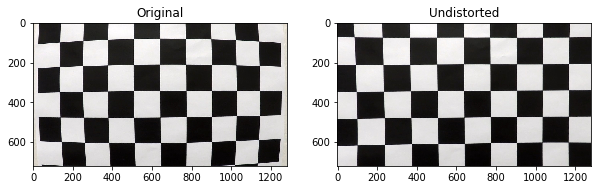

In [452]:
import random
import ntpath

%matplotlib inline

def sample_undistort(imageName):
    sample_images   = []
    image_name      = imageName
    original_image  = cv2.imread(image_name)
    undistort_image = undistort(original_image)
    filename        = ntpath.basename(imageName)
    
    cv2.imwrite(OUTPUT_DIR + 'undistort/original_'    + filename, original_image)
    cv2.imwrite(OUTPUT_DIR + 'undistort/undistorted_' + filename, undistort_image)

    original_image  = cv2.cvtColor(original_image,  cv2.COLOR_BGR2RGB)
    undistort_image = cv2.cvtColor(undistort_image, cv2.COLOR_BGR2RGB)

    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(10, 5))
    axes      = axes.ravel()

    axes[0].imshow(original_image)
    axes[0].set_title("Original")
    axes[1].imshow(undistort_image)
    axes[1].set_title("Undistorted")

sample_undistort("camera_cal/calibration1.jpg")

This are some examples of the undistort function. The first image shows more clearly the enhancing done by the function.

The distortion correction is done in the function **undistort**, that uses **cv2.undistort** method. This methods uses the the camera matrix and the distortion coeficients, which is calculated only one time during the execution, given that all the images to process will come from the same camera. This is done at the beggining of the declaration of functions that is before this section.

### Image Enhancing Pipeline Sample

True

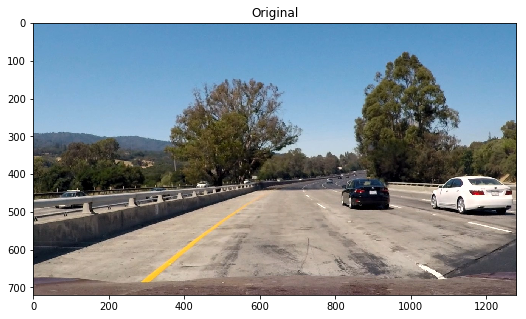

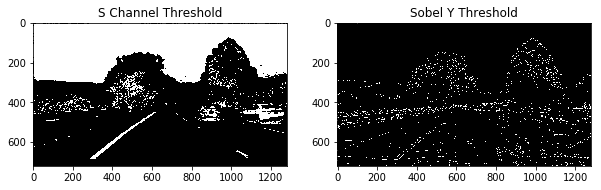

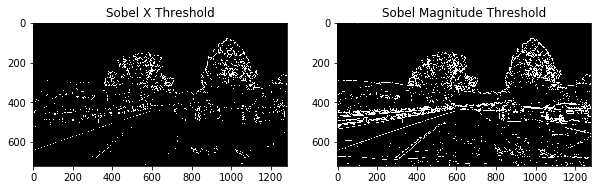

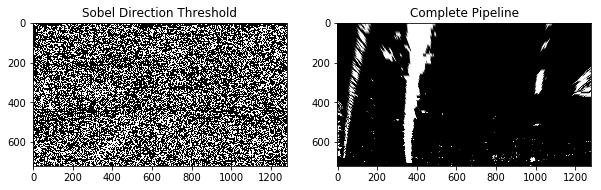

In [433]:
image_name     = "test_images/test1.jpg"
original_image = cv2.imread(image_name)
s_channel_img = apply_s_channel_threshold(img = original_image, thresh_min = 110, thresh_max = 255)
sobel_x_img   = apply_sobel(original_image, 'x', thresh_min = 30, thresh_max = 100)
sobel_y_img   = apply_sobel(original_image, 'y', thresh_min = 30, thresh_max = 50)
sobel_mag_img = apply_sobel_magnitude(original_image, sobel_kernel = 5, mag_thresh = (30, 255))
sobel_dir_img = apply_sobel_direction_threshold(original_image, sobel_kernel = 3, thresh = (0.7, 1.3))
combined_img  = prepare_image(original_image)

# Plotting thresholded images
f, ax1 = plt.subplots(1, 1, figsize=(10, 5))
ax1.set_title('Original')
ax1.imshow(cv2.cvtColor(original_image,  cv2.COLOR_BGR2RGB))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.set_title('S Channel Threshold')
ax1.imshow(s_channel_img, cmap='gray')
ax2.set_title('Sobel Y Threshold')
ax2.imshow(sobel_y_img, cmap='gray')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.set_title('Sobel X Threshold')
ax1.imshow(sobel_x_img, cmap='gray')
ax2.set_title('Sobel Magnitude Threshold')
ax2.imshow(sobel_mag_img, cmap='gray')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.set_title('Sobel Direction Threshold')
ax1.imshow(sobel_dir_img, cmap='gray')
ax2.set_title('Complete Pipeline')
ax2.imshow(combined_img, cmap='gray')

filename = ntpath.basename(image_name)

s_channel_img[s_channel_img == 1] = 255
sobel_x_img[sobel_x_img == 1]     = 255
sobel_y_img[sobel_y_img == 1]     = 255
sobel_mag_img[sobel_mag_img == 1] = 255
sobel_dir_img[sobel_dir_img == 1] = 255
combined_img[combined_img == 1]   = 255

cv2.imwrite(OUTPUT_DIR + 'enhancing/original_'  + filename, original_image)
cv2.imwrite(OUTPUT_DIR + 'enhancing/s_channel_' + filename, s_channel_img)
cv2.imwrite(OUTPUT_DIR + 'enhancing/sobel_x_'   + filename, sobel_x_img)
cv2.imwrite(OUTPUT_DIR + 'enhancing/sobel_y_'   + filename, sobel_y_img)
cv2.imwrite(OUTPUT_DIR + 'enhancing/sobel_mag_' + filename, sobel_mag_img)
cv2.imwrite(OUTPUT_DIR + 'enhancing/sobel_dir_' + filename, sobel_dir_img)
cv2.imwrite(OUTPUT_DIR + 'enhancing/combined_'  + filename, combined_img)

To process the image to find the lanes, first it's necesary to do some pre processing so the features of the lanes are enhanced. For this, I used a combination of the thresholded images from:

* S channel threshold, with parameters thresh_min = 85, thresh_max = 255.
* Sobel X transformation, with thresh_min = 30, thresh_max = 100
* Sobel Y transformation, with thresh_min = 30, thresh_max = 50
* Sobel magnitude transform, with kernel size = 5, mag_thresh = (30, 255)
* Sobel direction transform, with kernel size = 3, threshold = (0.7, 1.3)

I chose this parameters based on the outputs I got processing the images in the test set. This implementation is in my code in the function **prepare_image**, that combines the binary image output from the functions: 

* **apply_s_channel_threshold**: Applies the S channel selection and thresholding.
* **apply_sobel**: Applies the sobel transform and thresholding. Depending on the orient parameter, selects if the transform will be done for x or y.
* **apply_sobel_magnitude**: Applies sobel magnitude transform and thresholding.
* **apply_sobel_direction_threshold**: Applies sobel direction transform and thresholding.

At the end of the enhancing process, done on **prepare_image**, the image is warped, doing a perspective transformation. For this, I selected an area that is similar to the one on P1, but adjusted so it can fit better the orientation of the lanes. I used GIMP to draw lines to get the approximate points that could work for the warp source area. 

The points of the areas are the following (x,y):

| Source Point  | Destination Point|
| ------------- |:-------------:   |
| 570, 460      | 320, 0           |
| 710, 460      | 960, 0           | 
| 180, 720      | 320, 720         |
| 1130, 720     | 960,720          |

For the perspective transform process, I used **cv2.getPerspectiveTransform** and then the **cv2.warpPerspective** function. This is done on the **warpPerspective** function declared before.

### Samples of the source and destination areas before and after the perspective transform

This section show examples of the selected areas used for the perspective transform.

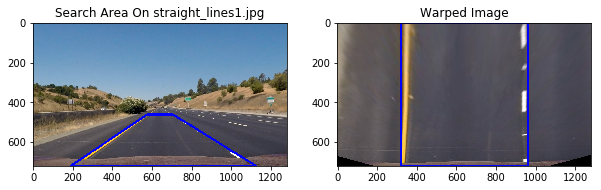

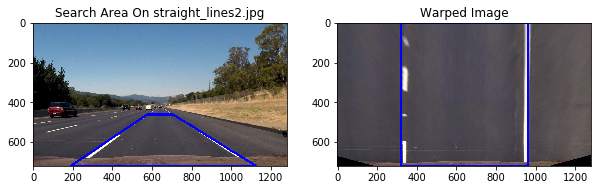

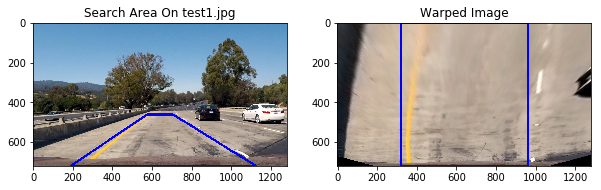

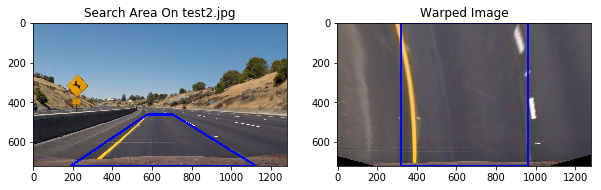

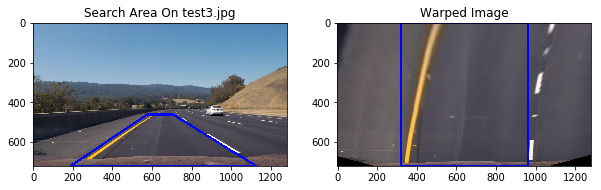

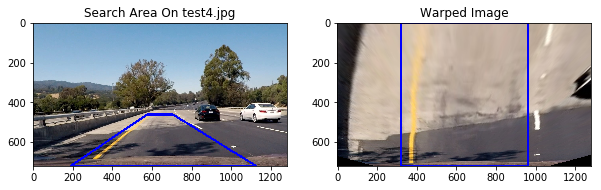

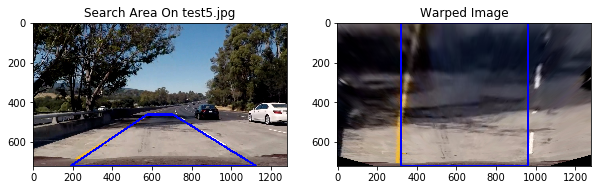

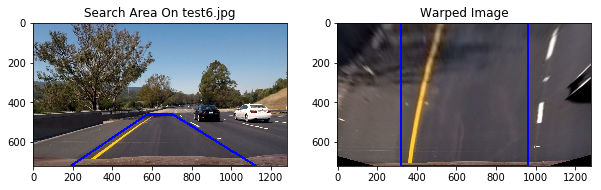

In [435]:
from itertools import chain

def draw_search_area(image_name):
    filename            = ntpath.basename(image_name)
    original_image      = cv2.imread(image_name)
    warpedImage         = warpPerspective(original_image)
    vertices            = get_search_area_vertices()
    target              = warp_destination_area
    src_top_line        = []
    src_base_line       = []
    src_left_side_line  = []
    src_right_side_line = []
    dst_top_line        = []
    dst_base_line       = []
    dst_left_side_line  = []
    dst_right_side_line = []
    
    src_top_line.append(vertices[0])
    src_top_line.append(vertices[3])
    src_base_line.append(vertices[1])
    src_base_line.append(vertices[2])
    src_left_side_line.append(vertices[0])
    src_left_side_line.append(vertices[1])
    src_right_side_line.append(vertices[3])
    src_right_side_line.append(vertices[2])
    
    dst_top_line.append(target[0])
    dst_top_line.append(target[3])
    dst_base_line.append(target[1])
    dst_base_line.append(target[2])
    dst_left_side_line.append(target[0])
    dst_left_side_line.append(target[1])
    dst_right_side_line.append(target[3])
    dst_right_side_line.append(target[2])    
    
    draw_line(original_image, np.int32([list(chain.from_iterable(src_top_line))]))
    draw_line(original_image, np.int32([list(chain.from_iterable(src_base_line))]))
    draw_line(original_image, np.int32([list(chain.from_iterable(src_left_side_line))]))
    draw_line(original_image, np.int32([list(chain.from_iterable(src_right_side_line))]))
    
    draw_line(warpedImage, np.int32([list(chain.from_iterable(dst_top_line))]))
    draw_line(warpedImage, np.int32([list(chain.from_iterable(dst_base_line))]))
    draw_line(warpedImage, np.int32([list(chain.from_iterable(dst_left_side_line))]))
    draw_line(warpedImage, np.int32([list(chain.from_iterable(dst_right_side_line))]))

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.set_title('Search Area On {}'.format(filename))
    ax1.imshow(cv2.cvtColor(original_image,  cv2.COLOR_BGR2RGB))
    ax2.set_title('Warped Image')
    ax2.imshow(cv2.cvtColor(warpedImage,  cv2.COLOR_BGR2RGB))

    cv2.imwrite(OUTPUT_DIR + 'search_area/original_' + filename, original_image)
    cv2.imwrite(OUTPUT_DIR + 'search_area/warped_'   + filename, warpedImage)

test_images = glob.glob('test_images/*.jpg')
test_images.sort()

for idx, fname in enumerate(test_images):
    draw_search_area(fname)

This are examples of the source warp points, and the output of the transformation.

## Lane Finding

### Show Histogram

After having prepared the image to enhance the features of the lanes, its necesary to calculate the histogram of the image, that permits to visualize the concentration of points that can represent a lane. Below theres examples of histogram for the warped test images.

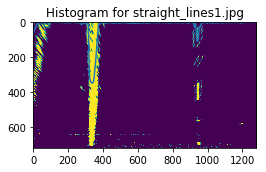

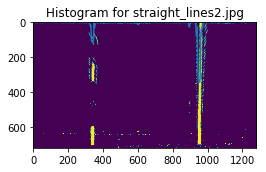

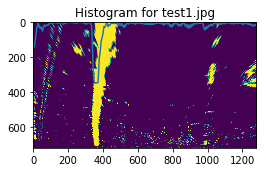

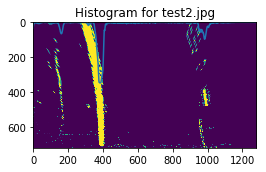

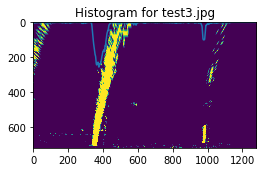

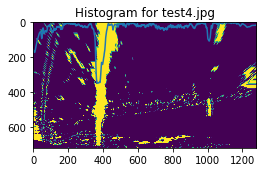

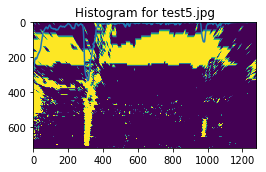

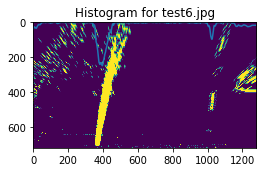

In [290]:
def show_histogram(image_name):
    original_image = cv2.imread(image_name)
    processed_img  = prepare_image(original_image)
    histogram      = np.sum(processed_img[int(processed_img.shape[0]/2):,:], axis=0)

    f, (ax1) = plt.subplots(1, 1, figsize=(4, 4))
    ax1.set_title('Histogram for {}'.format(ntpath.basename(image_name)))
    ax1.plot(histogram)
    ax1.imshow(processed_img)

test_images = glob.glob('test_images/*.jpg')
test_images.sort()

for idx, fname in enumerate(test_images):
    show_histogram(fname)


In this examples, it's visualized how the histogram show higher values around the lane areas.

### Find Lanes Polynomial Fits

Below is the implementation of the functions that I used for detecting the lanes.

First, I declarated an object similar to the one suggested in the lectures. I added start, end, and slope as members of the class.

* **initial_lane_search** implements the logic for identifying the lane pixels, using the sliding window search method. With this, the algorithm finds the pixels that belong to the lanes, and fits a polynomial that represents a curve that covers them. This method fills the line objects that gets as parameters with the information of the lanes. Also, calculates the curvature, done on the *calculate_curvature* function, that uses the distance between the lines and the polynomial that fits a given line, to calculate the radius.
* **calculate_offset** calculates the distance of the center of the car, to the center of the lane. This is done scaling the distant in pixels to the scale in meters.
* **cached_lane_search** This implements the use of the cache of line info of the last images, to improve the performance, precision and smoothing of the line detection process. Basically, used an average fit of the last 10 images to generate the points for the current image. I added a validation that based on the standard deviation of the distance between lanes, validates if the detection is correct, or is not accurate. This sets the detected property from the line objects, so in the next frame the detection is done from scratch again.

In [464]:
from collections import deque

LANE_CACHE_LIMIT = 10

class Line:
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = deque(maxlen = LANE_CACHE_LIMIT)
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        # Line fit for this lane
        self.slope = None
        # Line start
        self.startx = None
        # Line end
        self.endx = None

def calculate_curvature(ploty, lane_poly_fit, distance_lanes):
    """
    Get the curvature of polynomial.
    @params:
        ploty         - Required  : plot points.
        lane_poly_fit - Required  : Polynomial that fits the curve. 
    """
    ym_per_pix = 30  / 720 # meters per pixel in y dimension
    xm_per_pix = 3.7 / distance_lanes # meters per pixel in x dimension
    y_eval     = np.max(ploty)
    fit_cr     = np.polyfit(ploty * ym_per_pix, lane_poly_fit  * xm_per_pix, 2)
    return ((1 + (2 * fit_cr[0]  * y_eval * ym_per_pix + fit_cr[1])  ** 2) ** 1.5) / np.absolute(2 * fit_cr[0])

def calculate_offset(image_shape, left_lane, right_lane):
    """
    Calculates the offset from the center of the image and the center of the lanes.
    @params:
        image_shape - Required  : The shape of the image.
        left_x      - Required  : Array of values in X for the points of the left lane.
        right_x     - Required  : Array of values in X for the points of the right lane.
    """
    xm_per_pix          = 3.7 / abs(right_lane.endx - left_lane.endx) # meters per pixel in x dimension
    screen_middel_pixel = image_shape[1] / 2
    left_lane_pixel     = left_lane.endx   # x position for left lane
    right_lane_pixel    = right_lane.endx  # x position for right lane
    car_middle_pixel    = int((right_lane_pixel + left_lane_pixel) / 2)
    pixels_off_center   = screen_middel_pixel - car_middle_pixel
    meters_off_center   = round(xm_per_pix * pixels_off_center, 2)
    
    return meters_off_center

def get_average_line(lines):
    """
    Gets the average line from the a series of lines.
    @params:
        lines - Required  : The lines.
    """
    lines    = np.squeeze(lines)
    avg_line = np.zeros((720))

    for line in enumerate(reversed(lines)):
        avg_line += line

    avg_line = avg_line / len(lines)

    return avg_line

def cached_lane_search(binary_warped, left_line, right_line):
    """
    Get the lane info from the image, using data from previous searchs.
    @params:
        binary_warped - Required  : The binary warped image (byte array).
    """
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero   = binary_warped.nonzero()
    nonzeroy  = np.array(nonzero[0])
    nonzerox  = np.array(nonzero[1])
    margin    = 100
    left_fit  = left_line.current_fit
    right_fit = right_line.current_fit
    
    left_lane_inds  = ((nonzerox > (left_fit[0]  * (nonzeroy ** 2) + left_fit[1]  * nonzeroy + left_fit[2]  - margin)) & (nonzerox < (left_fit[0]  * (nonzeroy ** 2) + left_fit[1]  * nonzeroy + left_fit[2]  + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0] * (nonzeroy ** 2) + right_fit[1] * nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0] * (nonzeroy ** 2) + right_fit[1] * nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx  = nonzerox[left_lane_inds]
    lefty  = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit  = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty      = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx  = left_fit[0]  * ploty ** 2 + left_fit[1]  * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
    
    left_line.recent_xfitted.append(left_fitx)
    right_line.recent_xfitted.append(right_line)
    
    #Get the averages for both lines and generate the points, if I have enough data
    if len(left_line.recent_xfitted) > LANE_CACHE_LIMIT:
        left_avg_line         = get_average_line(left_line.recent_xfitted, LANE_CACHE_LIMIT)
        left_avg_fit          = np.polyfit(ploty, left_avg_line, 2)
        left_fit_plotx        = left_avg_fit[0] * ploty ** 2 + left_avg_fit[1] * ploty + left_avg_fit[2]
        left_line.current_fit = left_avg_fit
        left_line.allx        = left_fit_plotx
        left_line.ally        = ploty
    else:
        left_line.current_fit = left_fit
        left_line.allx        = left_fitx
        left_line.ally        = ploty

    if len(right_line.recent_xfitted) > LANE_CACHE_LIMIT:
        right_avg_line         = get_average_line(right_line.recent_xfitted, LANE_CACHE_LIMIT)
        right_avg_fit          = np.polyfit(ploty, right_avg_line, 2)
        right_fit_plotx        = right_avg_fit[0] * ploty ** 2 + right_avg_fit[1] * ploty + right_avg_fit[2]
        right_line.current_fit = right_avg_fit
        right_line.allx        = right_fit_plotx
        right_line.ally        = ploty
    else:
        right_line.current_fit = right_fit
        right_line.allx        = right_fitx
        right_line.ally        = ploty
    
    left_line.startx  = left_line.allx[len(left_line.allx) - 1]
    right_line.startx = right_line.allx[len(right_line.allx) - 1]
    left_line.endx    = left_line.allx[0]
    right_line.endx   = right_line.allx[0]
    
    distance_lanes    = abs(right_line.endx - left_line.endx)
    left_line.radius  = calculate_curvature(left_line.ally,  left_line.allx , distance_lanes)
    right_line.radius = calculate_curvature(right_line.ally, right_line.allx, distance_lanes)
    
    #Get the standard deviation from the lane distance.
    lane_distance_std = np.std(right_line.allx - left_line.allx)
    
    # 25 is an average value I got experimenting with the distance on the lanes on the test images.
    if (lane_distance_std > 25):
        left_line.detected  = False
        right_line.detected = False
        left_line.recent_xfitted.clear()
        right_line.recent_xfitted.clear()
    
def initial_lane_search(binary_warped, left_line, right_line):
    """
    Get the lane info from the image.
    @params:
        binary_warped - Required  : The binary warped image (byte array).
    """
    histogram   = np.sum(binary_warped[int(binary_warped.shape[0] / 2):,:], axis = 0)
    midpoint    = np.int(histogram.shape[0] / 2)

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero  = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current  = np.argmax(histogram[:midpoint])
    rightx_current = np.argmax(histogram[midpoint:]) + midpoint
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds  = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low       = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high      = binary_warped.shape[0] - window * window_height
        win_xleft_low   = leftx_current  - margin
        win_xleft_high  = leftx_current  + margin
        win_xright_low  = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds  = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low)  & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds  = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx  = nonzerox[left_lane_inds]
    lefty  = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit   = np.polyfit(lefty,  leftx,  2)
    right_fit  = np.polyfit(righty, rightx, 2)
    
    ploty          = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    left_fitx      = left_fit[0]  * ploty ** 2 + left_fit[1]  * ploty + left_fit[2]
    right_fitx     = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
    left_fit_line  = np.polyfit(lefty,  leftx,  1)
    right_fit_line = np.polyfit(righty, rightx, 1)
    
    left_line.allx         = left_fitx
    left_line.ally         = ploty
    left_line.current_fit  = left_fit
    left_line.slope        = left_fit_line[0]
    left_line.startx       = left_fitx[len(left_line.allx) - 1]
    left_line.endx         = left_fitx[0]
    left_line.detected     = True
    
    right_line.allx        = right_fitx
    right_line.ally        = ploty
    right_line.current_fit = right_fit
    right_line.slope       = right_fit_line[0]
    right_line.startx      = right_fitx[len(right_fitx) - 1]
    right_line.endx        = right_fitx[0]
    right_line.detected    = True
    
    distance_lanes    = abs(right_line.endx - left_line.endx)
    left_line.radius  = calculate_curvature(ploty, left_fitx,  distance_lanes)
    right_line.radius = calculate_curvature(ploty, right_fitx, distance_lanes)

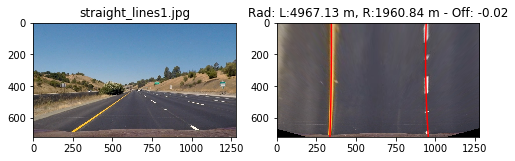

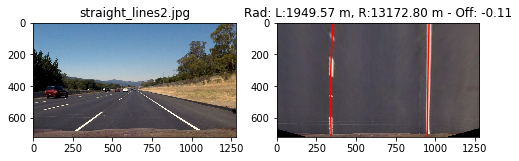

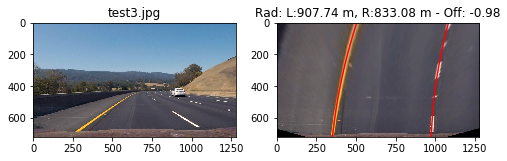

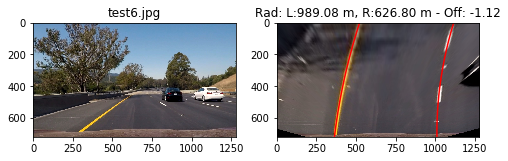

In [471]:
def test_lane_fit(image_name):
    left_lane       = Line()
    right_lane      = Line()
    original_image  = cv2.imread(image_name)
    binary_warped   = prepare_image(original_image)
    warped_original = warpPerspective(original_image)
    
    initial_lane_search(binary_warped, left_lane, right_lane)
    
    standard = np.std(right_lane.allx - left_lane.allx)   
    offset = calculate_offset(binary_warped.shape, left_lane, right_lane)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 5))
    ax1.set_title(ntpath.basename(image_name))
    ax1.imshow(cv2.cvtColor(original_image,  cv2.COLOR_BGR2RGB))
    ax2.set_title('Rad: L:{:.2f} m, R:{:.2f} m - Off: {:.2f}'.format(left_lane.radius, right_lane.radius, offset))
    ax2.imshow(cv2.cvtColor(warped_original,  cv2.COLOR_BGR2RGB))
    ax2.plot(left_lane.allx,  left_lane.ally,  color='red')
    ax2.plot(right_lane.allx, right_lane.ally, color='red')
    
test_lane_fit("test_images/straight_lines1.jpg")
test_lane_fit("test_images/straight_lines2.jpg")
test_lane_fit("test_images/test3.jpg")
test_lane_fit("test_images/test6.jpg")

This are examples of the plotted lines over the lines of the lanes.

### Image Processing Pipeline

The following code shows the starting point for the image processing pipeline, that will be used for processing the video frames.

* *hist_left_lane* and *hist_right_lane* stores the information of past lines found. **initialize** sets the initial state for this variables.
* **process_image** runs all the process pipeline on a given image. First, it prepares the image for processing using **prepare_image**, which returns a binary warped image that is the combination of the image filters described before. Next, determines if in past iterations the lines has been detected. If they hasn't, runs the a search from scratch, implemented on **initial_lane_search**; however, if the lines were detected in previous iterations, a search based on the averages of the last findings is done. This is implemented in the **cached_lane_search** function.

In [466]:
hist_left_lane  = Line()
hist_right_lane = Line()

def initialize():
    hist_left_lane  = Line()
    hist_right_lane = Line()

def process_image(image):
    """
    Process an image of the road, find lanes, and draws them.
    @params:
        image - Required  : The image.
    """    
    warped = prepare_image(image)
    
    if (hist_right_lane.detected):
        cached_lane_search(warped, hist_left_lane, hist_right_lane)
    else:
        initial_lane_search(warped, hist_left_lane, hist_right_lane)
        
    # Validate if the slopes of both lanes are really too different
    slope_diff = abs(hist_right_lane.slope - hist_left_lane.slope)

    if (slope_diff > 0.4):
        return image
        
    # Create an image to draw the lines on
    warp_zero  = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left  = np.array([np.transpose(np.vstack([hist_left_lane.allx, hist_left_lane.ally]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([hist_right_lane.allx, hist_right_lane.ally])))])
    pts       = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, np.linalg.inv(p_mtx), (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    radius    = (hist_right_lane.radius + hist_left_lane.radius) / 2
    offset    = calculate_offset(warped.shape, hist_left_lane, hist_right_lane)
    font      = cv2.FONT_HERSHEY_SIMPLEX
    color     = (0, 0, 255)
    cv2.putText(result, "Lane Radius: {:.2f}m".format(radius), (0, 100), font, 2, color = color, thickness = 7)
    cv2.putText(result, "Lane Offset: {:.2f}m".format(offset), (0, 200), font, 2, color = color, thickness = 7)
    
    return result

### Image Processing Pipeline Sample

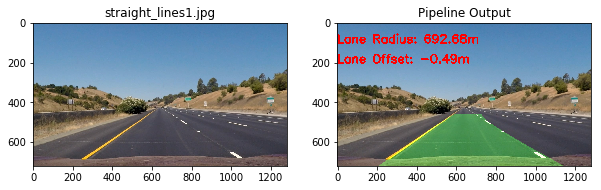

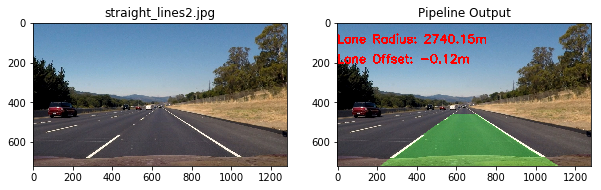

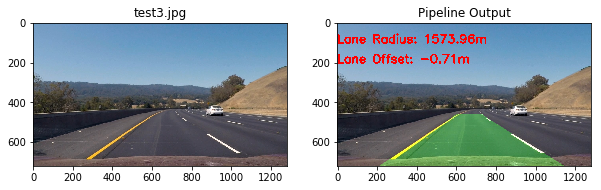

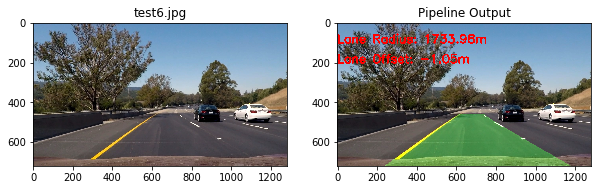

In [472]:
def test_processing_pipeline(fname):
    initialize()
    
    filename       = ntpath.basename(fname)
    original_image = cv2.imread(fname)
    output_image   = process_image(original_image)
        
    f, (ax1, ax2)  = plt.subplots(1, 2, figsize=(10, 5))
    ax1.set_title(ntpath.basename(fname))
    ax1.imshow(cv2.cvtColor(original_image,  cv2.COLOR_BGR2RGB))
    ax2.set_title('Pipeline Output')
    ax2.imshow(cv2.cvtColor(output_image,  cv2.COLOR_BGR2RGB))
    cv2.imwrite(OUTPUT_DIR + 'processed/processed_'   + filename, output_image)

test_processing_pipeline("test_images/straight_lines1.jpg")
test_processing_pipeline("test_images/straight_lines2.jpg")
test_processing_pipeline("test_images/test3.jpg")
test_processing_pipeline("test_images/test6.jpg")

Examples of images with the plotted road.

## Video Testing

In [468]:
initialize()

from moviepy.editor import VideoFileClip
yellow_output = 'project_video_processed.mp4'
clip2         = VideoFileClip('project_video.mp4')
yellow_clip   = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video project_video_processed.mp4
[MoviePy] Writing video project_video_processed.mp4


100%|█████████▉| 1260/1261 [04:48<00:00,  3.98it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_processed.mp4 

CPU times: user 6min 6s, sys: 2min 45s, total: 8min 51s
Wall time: 4min 50s


The video is on: https://youtu.be/DJJGUHAOoEY

# Discussion

My pipeline mostly fails when the color of the lanes, mostly the yellow one, is on an area where the surrounding areas are equal or more saturated than the lane area. This causes some confusion on the pipeline. An example is the test image number 5. I think to improve this, it's necesary to use not only the S channel thresholding, but also the H or L channel thresholding, and tuning the parameters of the other filters to enhance the lane features in this cases. My pipeline produces some wobbly lines, not catastrophic, that maybe can be improved with doing a better job filtering the image. 

I think the calculation for the curvature of the lanes is not that accurate in my case, given that is not consistent. I think this can be improved also with better image enhancing. 